# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

In [15]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder


In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [18]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [19]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

# 3 Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices and so on.

## 3.1 Read the Train and Test Data

In [20]:
train_X = load_dataset(context, 'train/housing/features')
train_y = load_dataset(context, 'train/housing/target')
print(train_X.shape, train_y.shape)

test_X = load_dataset(context, 'test/housing/features')
test_y = load_dataset(context, 'test/housing/target')
print(test_X.shape, test_y.shape)

(16512, 9) (16512, 1)
(4128, 9) (4128, 1)


In [65]:
import math
train_y['median_house_value']=train_y['median_house_value'].apply(lambda x: x + math.exp(-18.42))
test_y['median_house_value']=test_y['median_house_value'].apply(lambda x: x + math.exp(-18.42))

## 3.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

#### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [21]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns
print(num_columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')


#### Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer
- This will go into production code

In [22]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(16512, 9)
(16512, 9)


#### Encoding


Some sample pipelines showcasing how to create column specific pipelines and integrating them overall is presented below

- Commonly target encoding is done for categorical variables with too many levels.
- We also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- This will go into production code

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    train_X.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        temp_cols = X.columns.to_list()
        X=X.values
        temp_cols.extend(['rooms_per_household', 'population_per_household',
                         'bedrooms_per_room'])
        new_cols = {k:v for k,v in zip(range(len(temp_cols)),temp_cols)}
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            finaldf = pd.DataFrame(np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]).rename(columns=new_cols)
        else:
            finaldf = pd.DataFrame(np.c_[X, rooms_per_household, population_per_household]).rename(columns=new_cols)
        return finaldf
     

In [24]:
from sklearn.preprocessing import StandardScaler
attrib_adder=CombinedAttributesAdder()
cat=train_X['ocean_proximity']
train_X=attrib_adder.transform(train_X[num_columns])
num_cols=train_X.select_dtypes('number').columns
train_X['ocean_proximity']=cat
print(num_cols)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'population_per_household', 'bedrooms_per_room'],
      dtype='object')


In [25]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [27]:
features_transformer = ColumnTransformer([
    ("num", num_pipeline , num_cols),
    ("cat", OneHotEncoder(), cat_columns),
])

[[ 1.24693819 -1.32781903 -0.28552449 ...  0.          0.
   1.        ]
 [ 0.62705927 -0.71890811  0.5908656  ...  0.          0.
   0.        ]
 [ 1.15195675 -0.83600636 -1.32125823 ...  0.          0.
   0.        ]
 ...
 [-1.20258336  1.01414605 -0.9228991  ...  0.          0.
   0.        ]
 [-1.04761363  0.50359766  0.35185012 ...  0.          0.
   0.        ]
 [ 0.65205439 -0.75169562  0.98922473 ...  0.          0.
   0.        ]]


In [28]:
sample_X = train_X.sample(frac=0.1, random_state=context.random_seed)
sample_y = train_y.loc[sample_X.index]
housing=features_transformer.fit_transform(sample_X, sample_y)
sample_train_X = get_dataframe(
    features_transformer.fit_transform(sample_X, sample_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

# nothing to do for target
sample_train_y = sample_y

**Dev notes(Encoding):**
<details>

    Some common practices followed in Categorical Feature Encoding are
    * For categorical variables with too many levels, target encoding can be done.
    * For fewer levels, one hot encoding can be done.
    * If one very dominant level is observed, binary encoding can be used.
    
    
</details>

## 3.2 Feature analysis

Using the pipeline above analyze the features and decide on additional features to add/remove from the pipeline. This section will not be part of the production code, unless input data drifts etc. are explicitly demanded in the project.

Here we are primarily focused on feature selection/elimination based on business rules, prior knowledge, data analysis.

**We are not building any models at this point.**


- we create some sample data to analyze that we assume represent the population
- train the features transformer and do the analysis as below

Running the features transformer on the complete data

In [29]:
train_X = get_dataframe(
    features_transformer.fit_transform(train_X, train_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

### 3.2.1 Univariate


- Look at each variable independently. This is useful if your models have assumptions on the distribution and/or bounds on the features/target

In [30]:
train_X.columns

Index(['num_longitude', 'num_latitude', 'num_housing_median_age',
       'num_total_rooms', 'num_total_bedrooms', 'num_population',
       'num_households', 'num_median_income', 'num_rooms_per_household',
       'num_population_per_household', 'num_bedrooms_per_room',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [31]:
out = eda.get_density_plots(train_X, cols=['num_housing_median_age',
       'num_total_rooms', 'num_total_bedrooms', 'num_population',
       'num_households', 'num_median_income', 'num_rooms_per_household',
       'num_population_per_household', 'num_bedrooms_per_room'])
out

:DynamicMap   [col]
   :Layout
      .Overlay.I :Overlay
         .Histogram.I    :Histogram   [x]   (Frequency)
         .Distribution.I :Distribution   [num_housing_median_age]   (Density)
      .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [32]:
# save the plots are html
reports.create_report({'univariate': out}, name='feature_analysis_univariate')

A report containing the above plot is available [here](https://drive.google.com/file/d/1oqlhJ_GifdEXOT0mOqnGoOIwBt1e5jd2/view?usp=sharing)


Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1mWvPLC2eAEIfNqIYDKpWuAwP6kInkMbw/view?usp=sharing)

In [33]:
reports.feature_analysis(train_X,'./feature_analysis_report.html')

p-value may not be accurate for N > 5000.


### 3.2.2 Bivariate - mutual interactions

- Find columns with high correlations and drop them

In [34]:
out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,num_households,num_total_bedrooms,0.970478,0.970478
1,num_latitude,num_longitude,-0.924018,0.924018
2,num_total_bedrooms,num_total_rooms,0.918230,0.918230
3,num_households,num_total_rooms,0.911455,0.911455
4,num_households,num_population,0.907583,0.907583
5,num_population,num_total_bedrooms,0.869576,0.869576
6,num_population,num_total_rooms,0.840291,0.840291
7,num_bedrooms_per_room,num_median_income,-0.629107,0.629107
8,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,-0.605845,0.605845


In [35]:
# channel and source_channel highly correlated. So discarding source_channel
# brand and manufacturer are almost same so discarding manufacturer.
# Similarly keeping sku between inventory and sku
# Similarly keeping condition between conditions and ext_grade
# Similarly keeping model_family between platforms, ext_model_family and model_family
# Discarding selling price & selling cost as they are multiples of unit price/cost & quantity.
# Discarding gp as it is the of selling price and selling cost
# order_no, line, invoice_no & customername cannot be IDVs
curated_columns = list(
    set(train_X.columns.to_list()) 
    - set(['num_population_per_household',
        'ocean_proximity_NEAR OCEAN',  
       'num_rooms_per_household', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_<1H OCEAN'])
)

train_X = train_X[curated_columns]

out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,num_households,num_total_bedrooms,0.970478,0.970478
1,num_latitude,num_longitude,-0.924018,0.924018
2,num_total_bedrooms,num_total_rooms,0.918230,0.918230
3,num_households,num_total_rooms,0.911455,0.911455
4,num_households,num_population,0.907583,0.907583
5,num_population,num_total_bedrooms,0.869576,0.869576
6,num_population,num_total_rooms,0.840291,0.840291
7,num_bedrooms_per_room,num_median_income,-0.629107,0.629107


In [36]:
train_X.columns

Index(['num_bedrooms_per_room', 'num_total_rooms', 'num_median_income',
       'num_total_bedrooms', 'num_longitude', 'num_latitude',
       'num_housing_median_age', 'num_population', 'num_households'],
      dtype='object')

In [37]:
out = eda.get_bivariate_plots(train_X, x_cols=['num_households'], 
                              y_cols=['num_total_bedrooms'])
out

:HexTiles   [num_households,num_total_bedrooms]

In [38]:
%%time
# create reports as needed
cols = train_X.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols): 
    for jj in range(ii+1, len(cols)):
        col2 = cols[jj]
        out = eda.get_bivariate_plots(train_X, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

reports.create_report(all_plots, name='feature_analysis_bivariate')

CPU times: user 5.92 s, sys: 28.5 ms, total: 5.95 s
Wall time: 5.94 s


A report containing the bivariate plot is available [here](https://drive.google.com/file/d/1S3JXE1TTwuALugqL5I4zsRpjYy9vIXZy/view?usp=sharing)

Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/12o2Q7O6q2Zck0cHBQ36WDeWuy7b4athM/view?usp=sharing)

In [39]:
reports.feature_interactions(train_X,'./feature_interaction_report.html')

### 3.2.3 Key Drivers - Interaction with Target variable

In [40]:
out = eda.get_target_correlation(train_X, train_y)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')
    [1] HoloViews(Bars, name='mutual_information')

Tabs
    [0] HoloViews(Bars, name='from_model')
    [1] Matplotlib(Figure, name='shap_values')
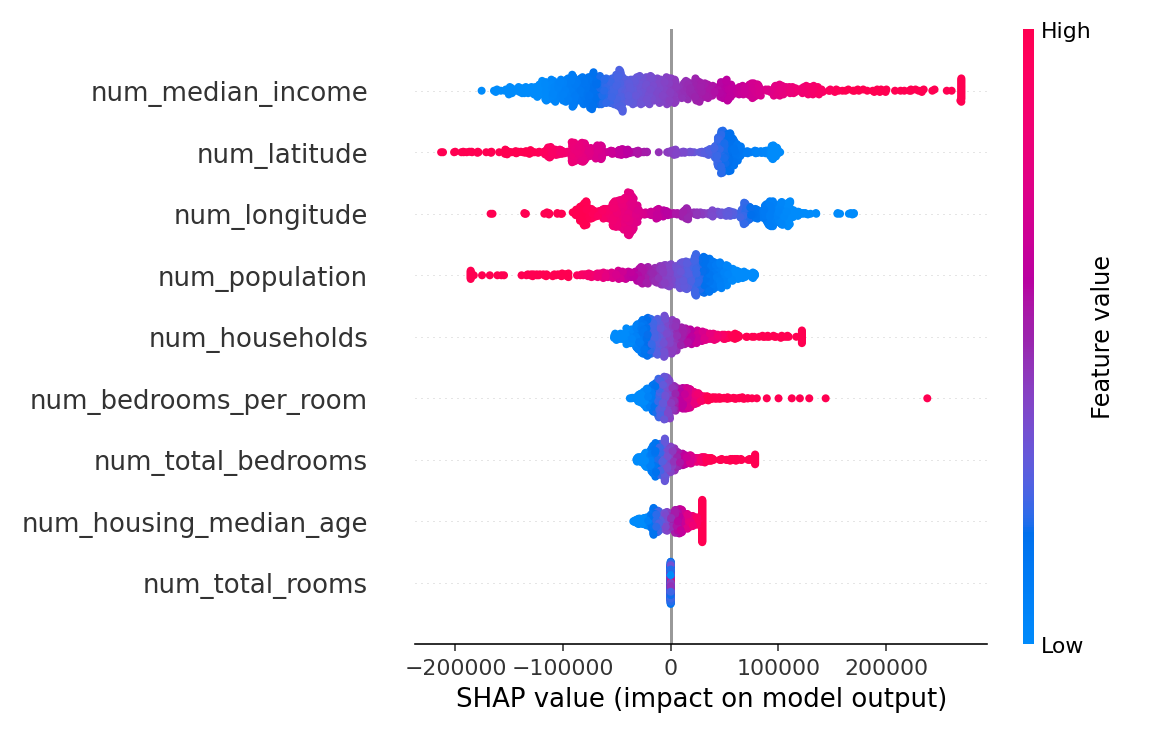

In [67]:
out = eda.get_feature_importances(train_X, train_y)
display_as_tabs([(k, v) for k,v in out.items()])

Key drivers report like feature importance, bivariate plots can be obtained as below

In [68]:
reports.key_drivers(train_X,train_y,'./key_drivers_report.html')

**Dev Notes**
<details>
    
- The SHAP plots and bivariate plots in key drivers reports can be obtained by including quick=False as a parameter to key_drivers function call. 
- SHAP plots and bivariate plots often take long depending on data shape.
- The plot with shap is present [here](https://drive.google.com/file/d/1JOTMBLiv3LEqZ-kxZz0RokW9v5UyiGva/view?usp=sharing)

</details>


All the plots like feature analysis, interaction, key drivers can be obtained as a single plot using data exploration method as shown below. The output from this is available [here](https://drive.google.com/file/d/1_3rE5u3qFHdeoL3VrFNTG-aBtHFALnI7/view?usp=sharing)

In [69]:
reports.data_exploration(train_X,train_y,'./data_exploration_report.html')

p-value may not be accurate for N > 5000.


In [41]:
# saving the list of relevant columns
save_pipeline(curated_columns, op.abspath(op.join(artifacts_folder, 'curated_columns.joblib')))

# save the feature pipeline
save_pipeline(features_transformer, op.abspath(op.join(artifacts_folder, 'features.joblib')))

# 4 Modelling

## 4.1 Modelling - Linear Regression

### 4.1.1 Feature Selection(Specific to Regression)

- Selecting Features specific to regression
- VIF : measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case to case basis VIF thresholds change. Generally 5 or 10 are acceptable levels.
- Usually on a recursive basis when removing the most collinear variable, there can be shuffle in VIF. 
- Often this section will not be part of the production code.

In [42]:
cols = list(train_X.columns)
vif = eda.calc_vif(train_X)
while max(vif.VIF) > 15:
    #removing the largest variable from VIF
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(train_X[cols])

In [43]:
reg_vars = vif.query('VIF < 15').variables
reg_vars = list(reg_vars)

### 4.1.2 Data transformations

In [44]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

### 4.1.3 Model training pipeline

- Here we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [45]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(train_X, train_y.values.ravel())


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f9f3816e820>,
                                     kw_args={'cols2keep': ['num_bedrooms_per_room',
                                                            'num_total_rooms',
                                                            'num_median_income',
                                                            'num_longitude',
                                                            'num_latitude',
                                                            'num_housing_median_age',
                                                            'num_population']})),
                ('estimator', SKLStatsmodelOLS())])

In [46]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     4456.
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:45:12   Log-Likelihood:            -2.0710e+05
No. Observations:               16512   AIC:                         4.142e+05
Df Residuals:                   16504   BIC:                         4.143e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept               2.068e+05    527.210    392.189      0.000    2.06e+05    2.08e+05
num_bedrooms_per_room   3.044e+04    735.925     41.369      0.000     2.9e+04    3.19e+04
num_total_rooms         4.401e+04   1156.714     38.046      0.000    4.17e+04    4.63e+04
num_median_income       8.292e+04    768.542    107.896      0.000    8.14e+04    8.44e+04
num_longitude          -7.894e+04   1553.390    -50.817      0.000    -8.2e+04   -7.59e+04
num_latitude           -8.316e+04   1588.296    -52.359      0.000   -8.63e+04      -8e+04
num_housing_median_age  1.601e+04    598.702     26.742      0.000    1.48e+04    1.72e+04
num_population          -3.87e+04   1114.970    -34.710      0.000   -4.09e+04   -3.65e+04
==============================================================================
Omnibus:                     3487.534   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10878.833
Skew:                           1.082   Prob(JB):                         0.00
Kurtosis:                       6.336   Cond. No.                         6.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.1.5 Model Evaluation(Linear Model)

This will be part of the production code.

In [47]:
reg_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('Linear Regression', SKLStatsmodelOLS())
])
cat=test_X['ocean_proximity']
test_X=attrib_adder.transform(test_X[num_columns])
num_cols=train_X.select_dtypes('number').columns
test_X['ocean_proximity']=cat
test_X = get_dataframe(
    features_transformer.transform(test_X), 
    get_feature_names_from_column_transformer(features_transformer)
)
test_X = test_X[curated_columns]

In [48]:
reg_linear_report = RegressionReport(model=reg_ppln, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='regression_linear_model_report')

In [70]:
save_pipeline(
        reg_ppln_ols, op.abspath(op.join(artifacts_folder, "train_pipeline.joblib"))
    )

**Dev Notes**
Use SHAP for variable interpretability.
<details>

    1. Use SHAP=True to generate variable interpretability plots in the report
    2. SHAP is recommended for non parameteric models such as RF, xgboost.
    3. However, SHAP reports are time consuming depending on no.of records and model complexity.
    
A sample of regerssion report with SHAP can be found [here](https://drive.google.com/file/d/18RlQTsT1ze09Cgz-qpb4ha_cvyWbN5F5/view?usp=sharing).
</details>

### 4.1.6 Residual Analysis
- After scoring the model, it is recommended to do a residual analysis to know the distribution of errors
- we took a threshold of 30% above which it is marked as over prediction or underprediction
- This will not be part of the production code.

In [49]:
threshold=0.3
residual_analysis = test_X.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(test_X)
residual_analysis['actuals'] = test_y.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [50]:
residual_analysis.hvplot.kde(y="num_total_rooms",by="forecast_flag", ## Grouping by Predictions
                                width=800, height=400,
                                alpha=0.7,
                                ylabel="density",
                                xlabel="num_total_rooms",
                                title=f'num_total_rooms(density)',legend='top_right')

:NdOverlay   [forecast_flag]
   :Distribution   [num_total_rooms]   (Density)

- From the above plot we can infer that the higher "over predictions" are happening for unit_cost > 200.
- similarly, the higher "under predictions" are happening for unit_cost is zero.

This can help us tune the model by a separate model for unit_cost > 200


# 4.2 Modelling - XGBoost

## 4.2.1 Model training pipeline

Here we focus on creating a collection of pipelines that can be used for tranining respective models.

Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.2.2 Model Pipeline Build

In [51]:
# let's find features for some decent defaults
estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(train_X, train_y)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

### 4.2.3 Model Tuning

<AxesSubplot:>

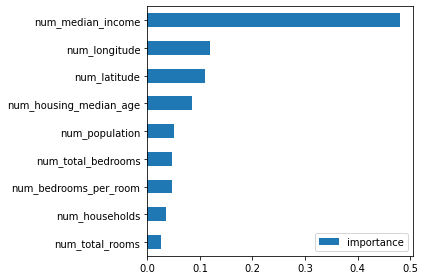

In [52]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = train_X.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

'condition','model_family','days_since_last_purchase','first_time_customer','sales_person', are considered to be important and in grid search

##### Pipeline build based on new importance features

In [53]:
# let's find features for some decent defaults
imp_features = []

estimator = XGBRegressor()
xgb_training_pipe2 = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', XGBRegressor())
])

#### Grid Search of the Estimator

In [54]:
%%time
parameters = {
   'gamma':[0.03],
   'min_child_weight':[6],
   'learning_rate':[0.1],
   'max_depth':[3],
   'n_estimators':[500], 
}
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(train_X, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.1s finished


0.8110126220241229
{'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 500}
CPU times: user 9.45 s, sys: 232 ms, total: 9.68 s
Wall time: 8.47 s


#### Pipeline Build using the best estimator

In [55]:
xgb_pipeline_final = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', xgb_grid.best_estimator_)
])
xgb_pipeline_final.fit(train_X, train_y)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f9f3816e820>,
                                     kw_args={'cols2keep': []})),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0.03, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=0, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
           

In [60]:
reg_tree_report = RegressionReport(model=xgb_pipeline_final,refit=True, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y)
reg_tree_report.get_report(include_shap=False, file_path='regression_tree_model_report')

The Regression report containing the feature importances are available [here](https://drive.google.com/file/d/1-VvhnH-TELL_SYQP1SA91KeGbSI48bCl/view?usp=sharing)

# 5 Model Comparison

Now, a comparison report of the  linear (vs) tree -based model  approach can be generated as follows.

This code will not be part of the production code.

In [66]:
model_pipelines = [reg_ppln, xgb_pipeline_final]
model_comparison_report = RegressionComparison(models=model_pipelines,x=train_X, y=train_y)
metrics = model_comparison_report.get_report(file_path='regression_comparison',include_shap=False)

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [62]:
model_comparison_report.performance_metrics

metric,MAPE,WMAPE,MAE,RMSE,R^2
", Linear Regression",0.2980,0.2384,49295.8945,67729.5520,0.6540
", XGBoost",0.1636,0.1412,29188.3233,42324.3732,0.8649


A report comparing the performance, metrics between Linear model and Tree model are available [here](https://drive.google.com/file/d/1t2VtBffSH5gfhxyaXZrfNufuRgMFZhc9/view?usp=sharing)

**Dev NOTES**
<details>

the above metrics are absolute nos and not %ges

In this example we are choosing LM model for pipelining. General criteria for choosing production models is:

- Parametric models (aka whitebox models) such as Linear Regression are easier to explain to non-technical audience.
- Generally these are accepted fast and adoption is quicker.
- If the downstream calls for optimization using these models parametric models are easier to implement.
- When accuracy is primary goal without explainability, the above two takes a backseat